In [1]:
# !pip install pandas matplotlib numpy

In [2]:
import os
import re
from pathlib import Path

from plotter import *
from plotter.epochstats import EpochStats
from plotter.plotepochstats import PlotRangeQueryStats
from plotter.plotselectivities import PlotSelectivities, PlotSelectivitiesRangeQuery
from plotter.dataclass import SelectivityVsMetric, SelectivityVsRangeQueryMetric
from plotter.utils import vanilla_dirname, rqdc_dirname

PROJECT_DIR = Path.cwd().parent.parent

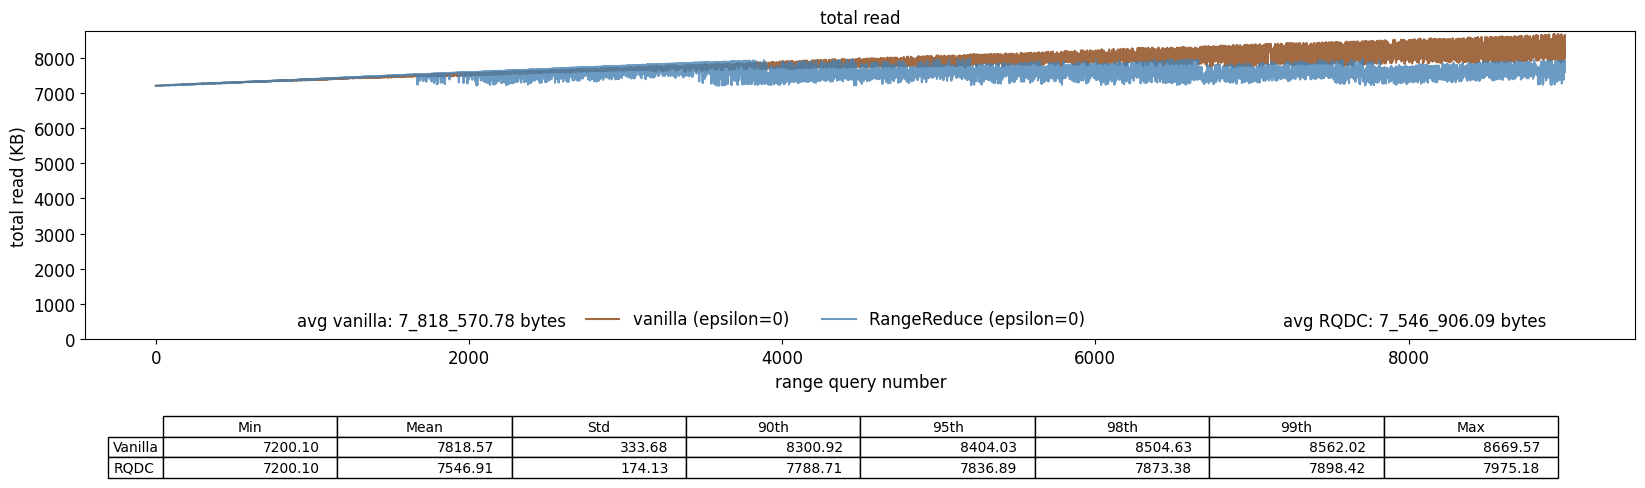

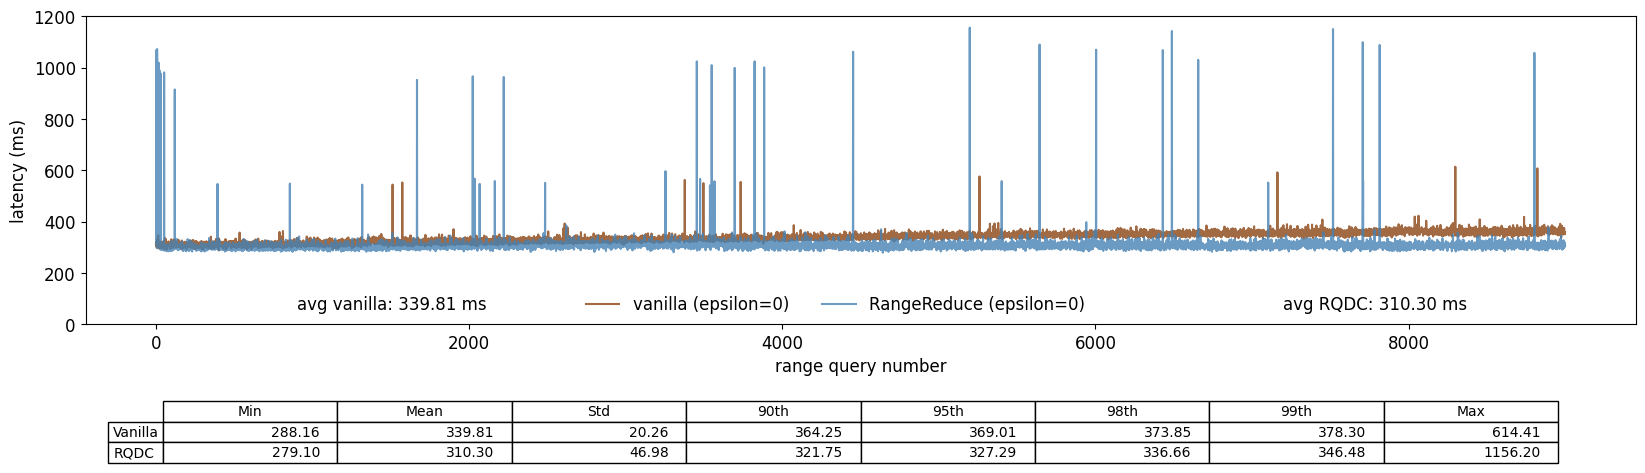

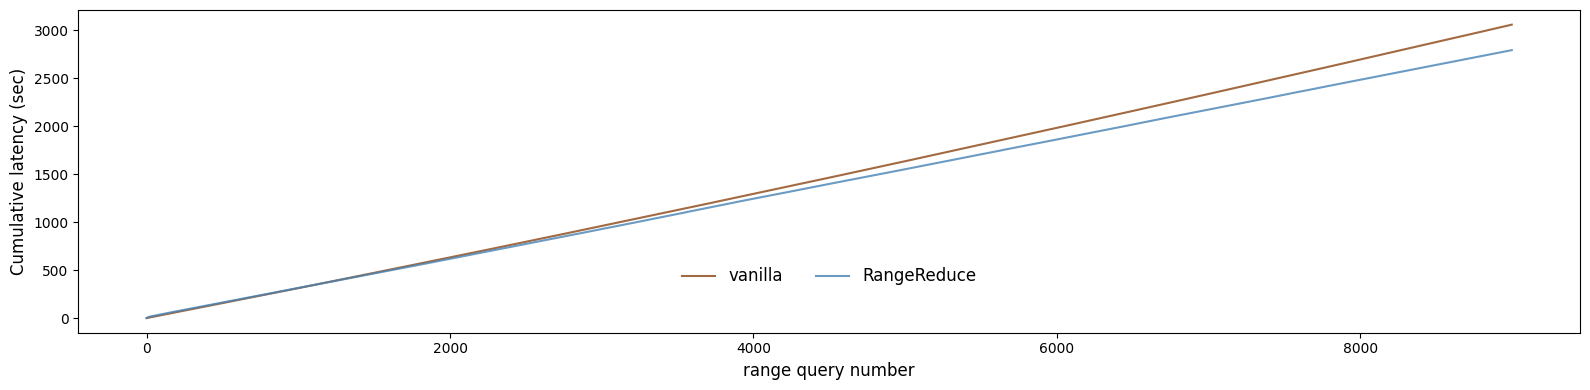

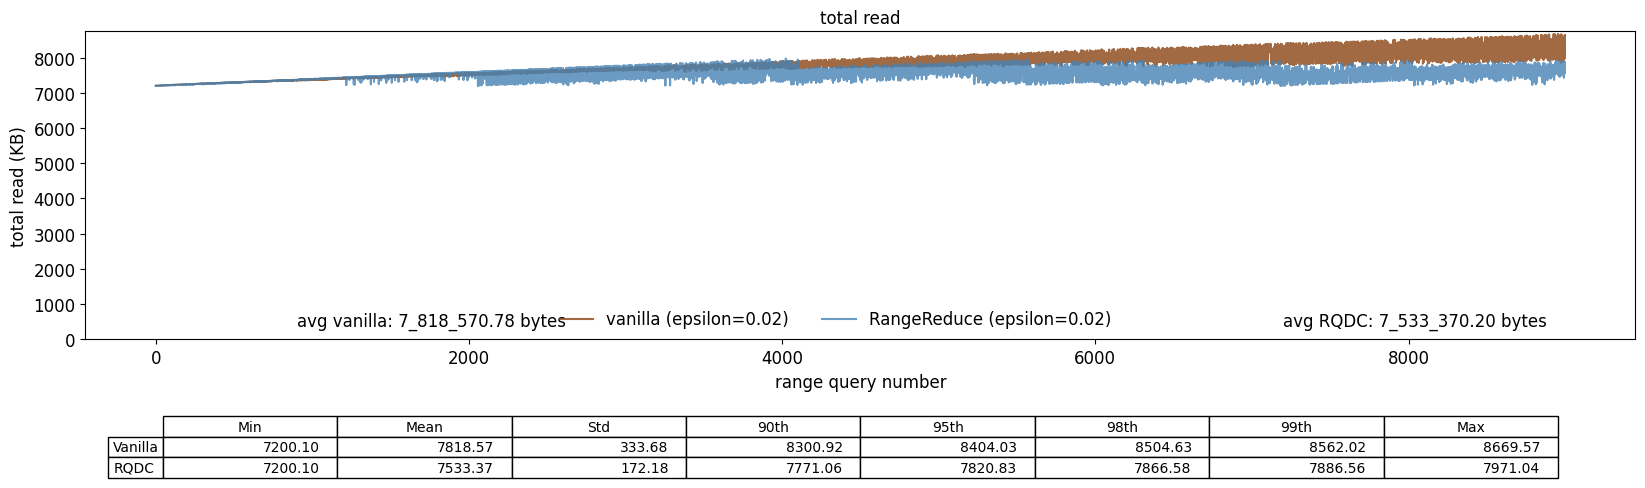

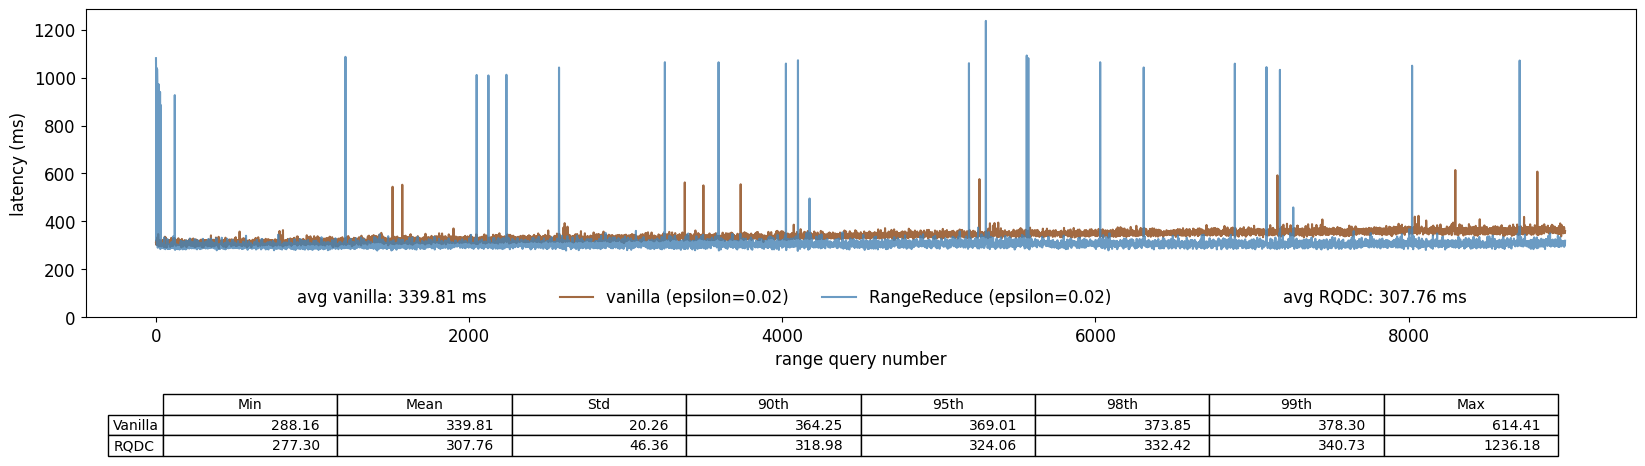

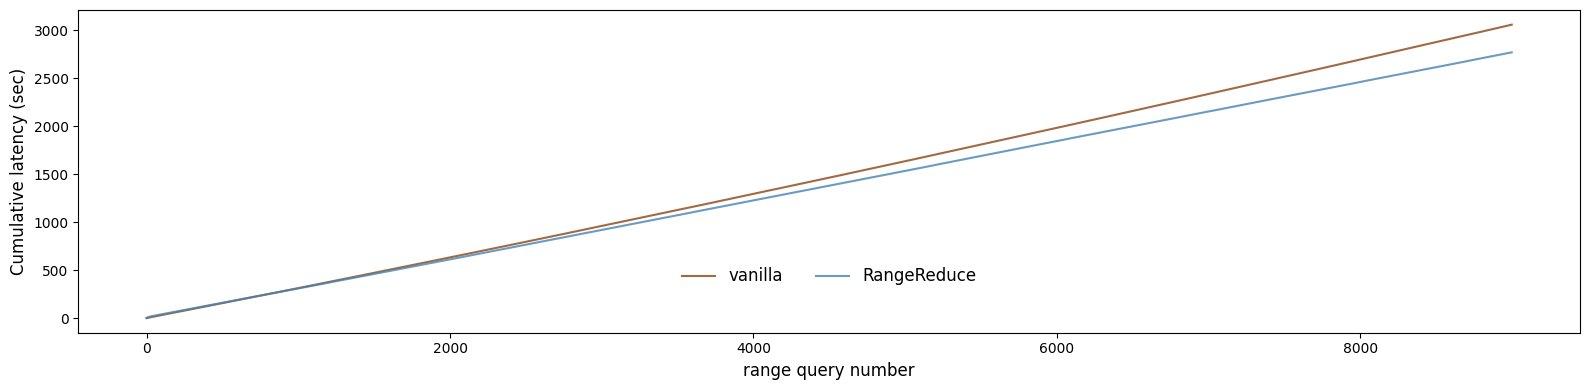

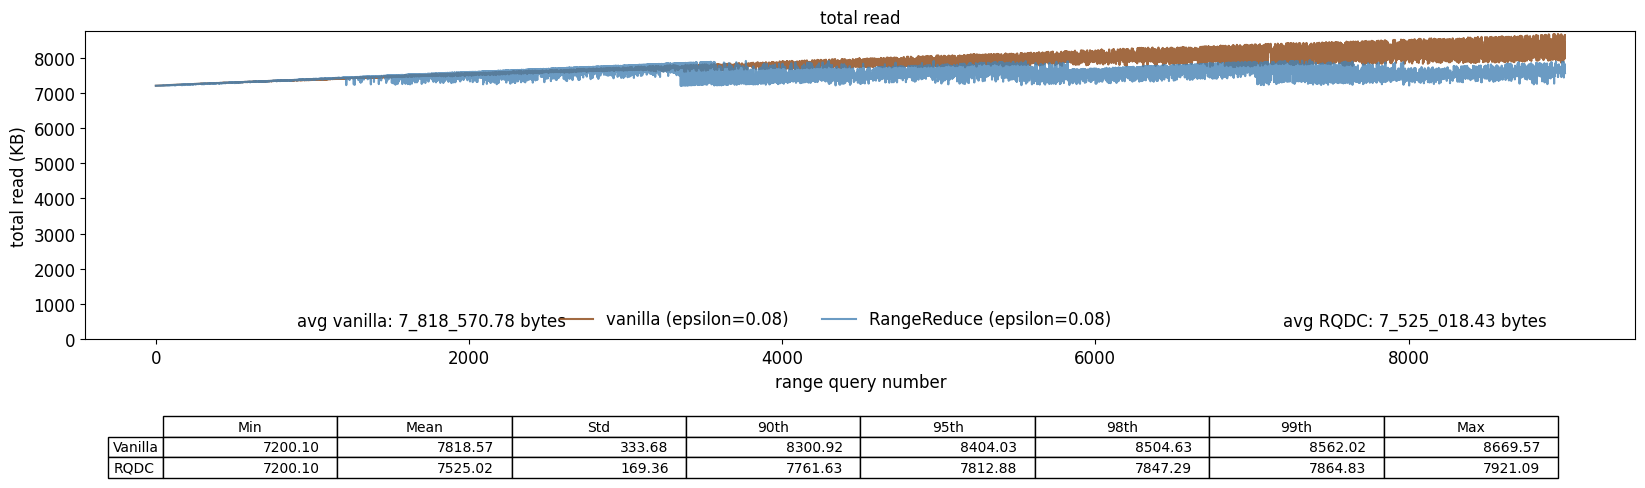

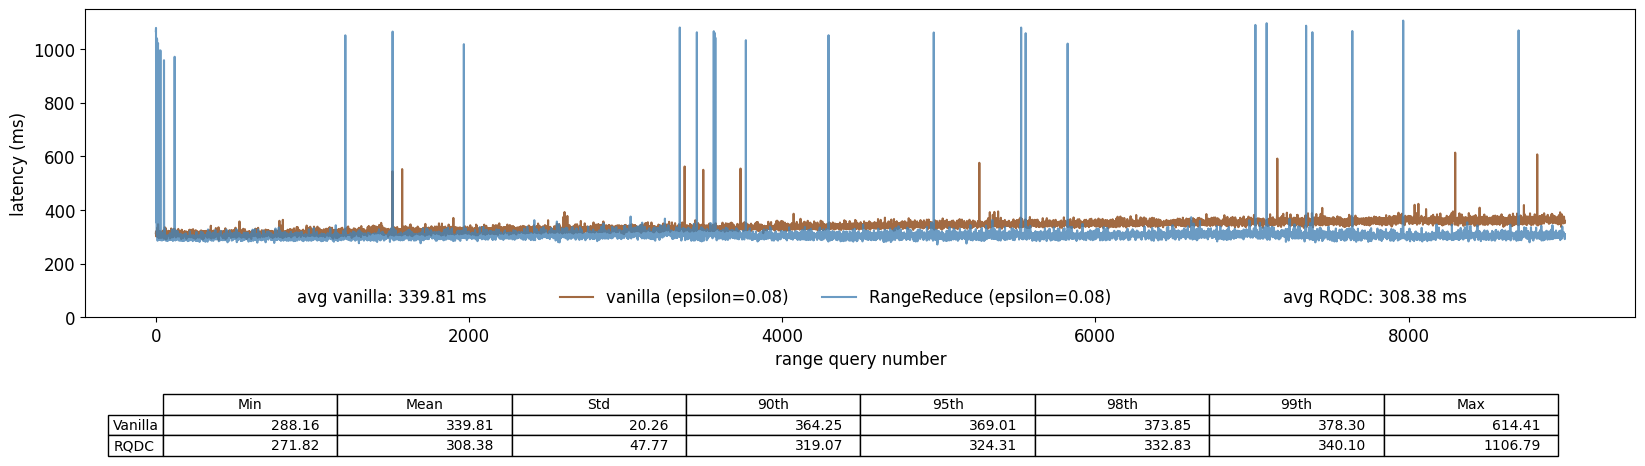

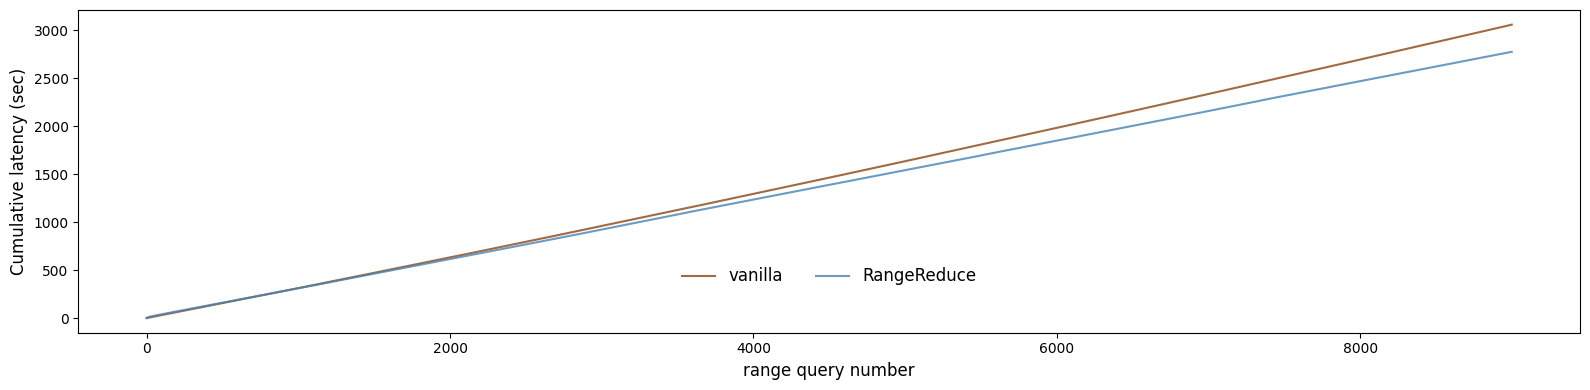

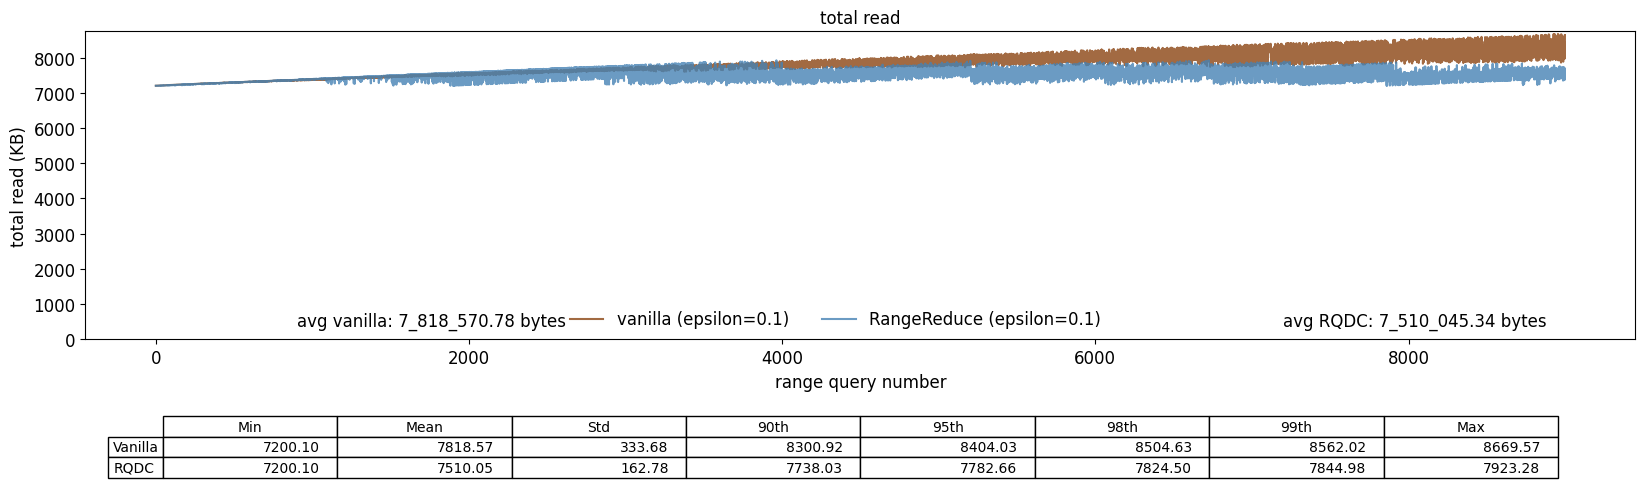

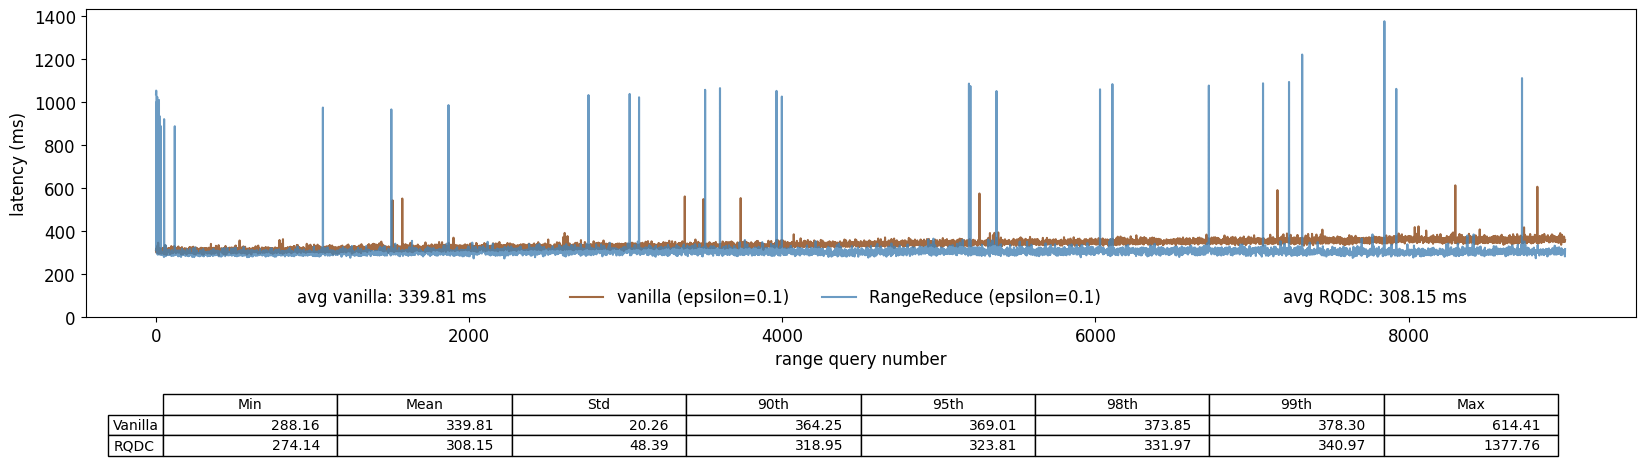

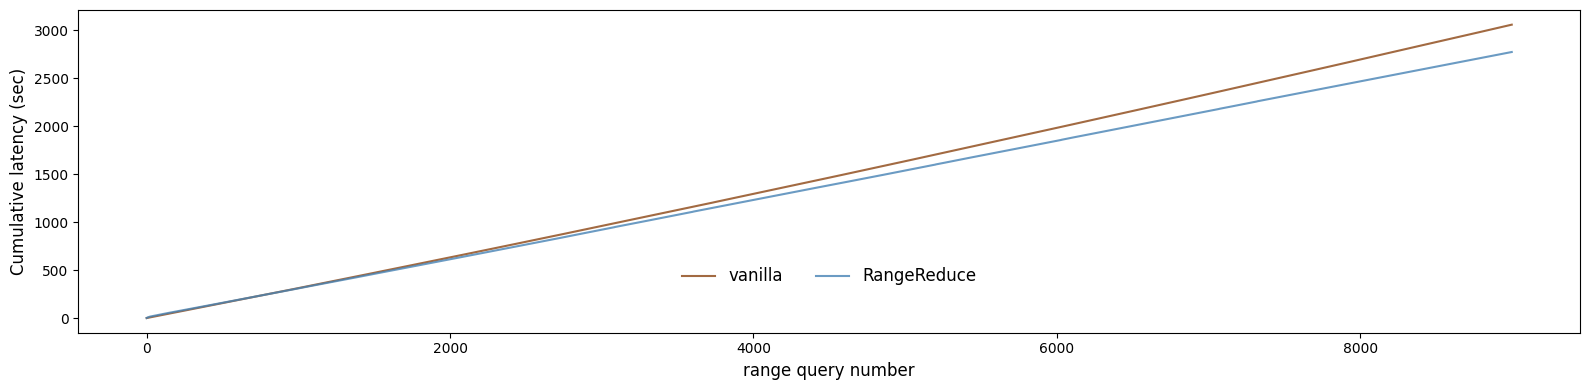

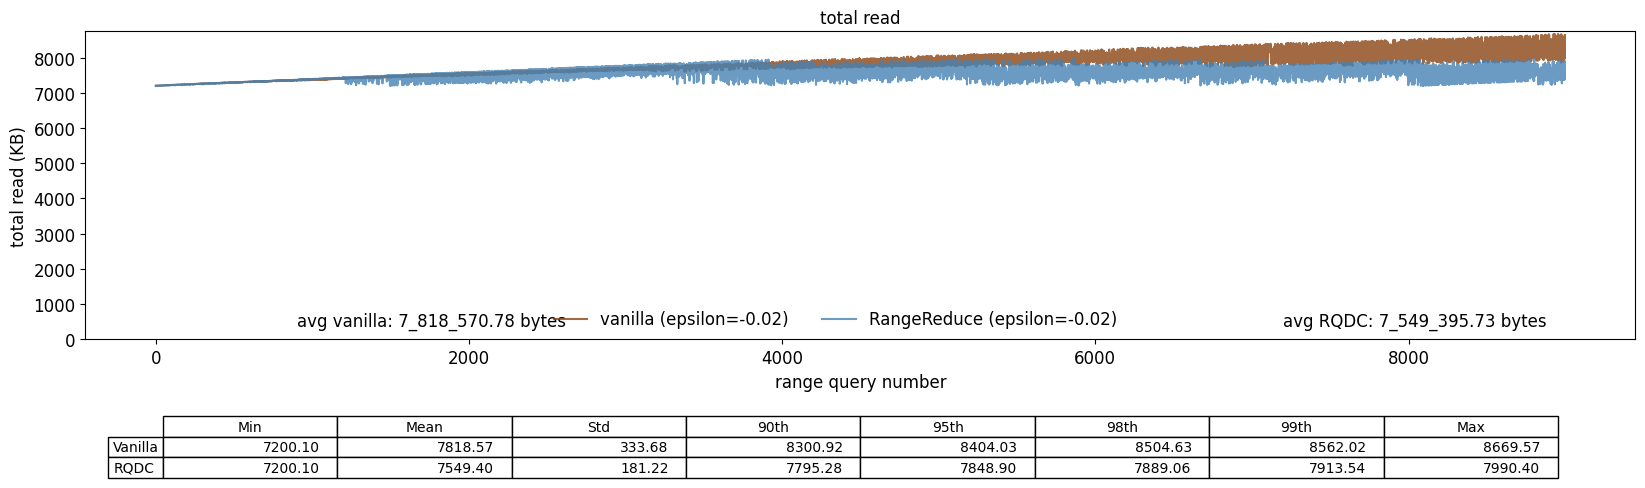

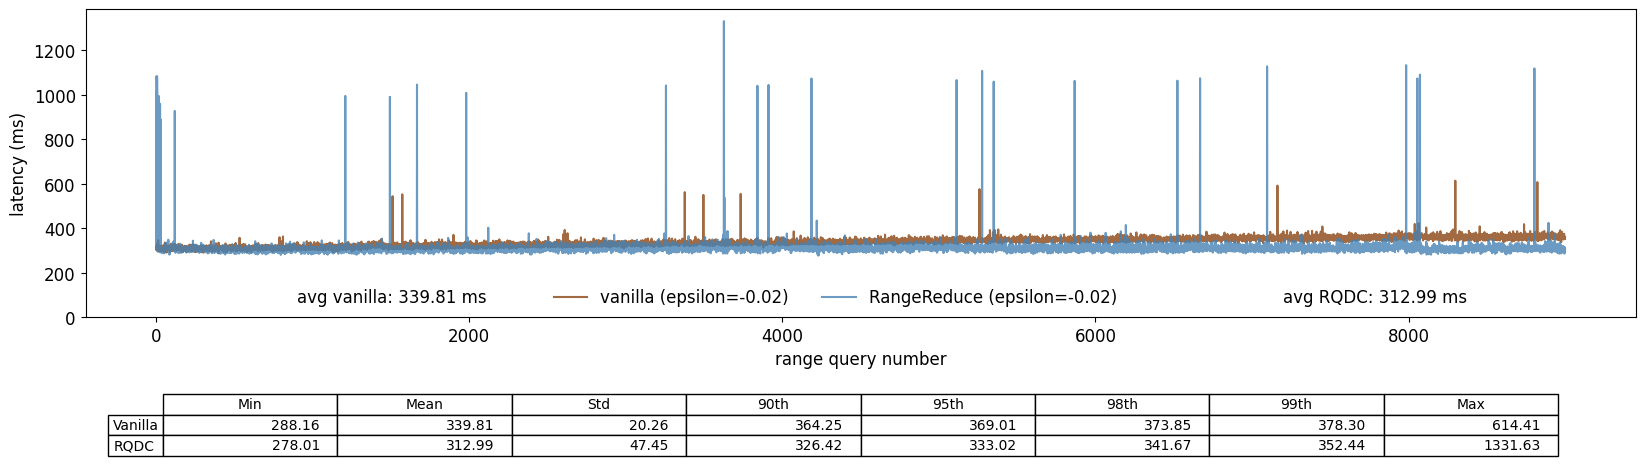

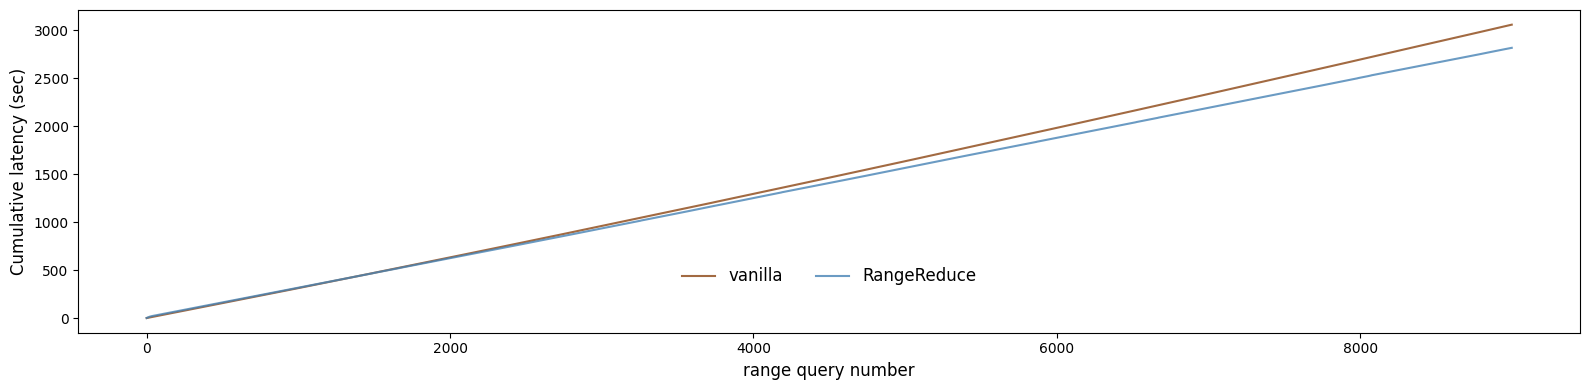

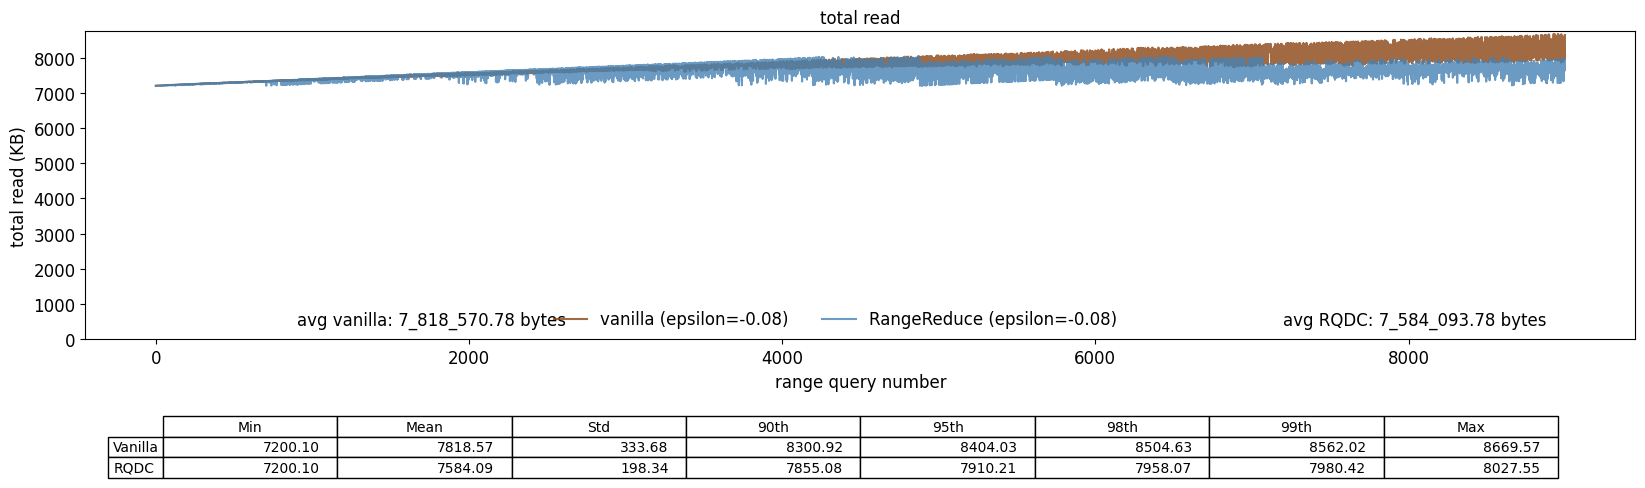

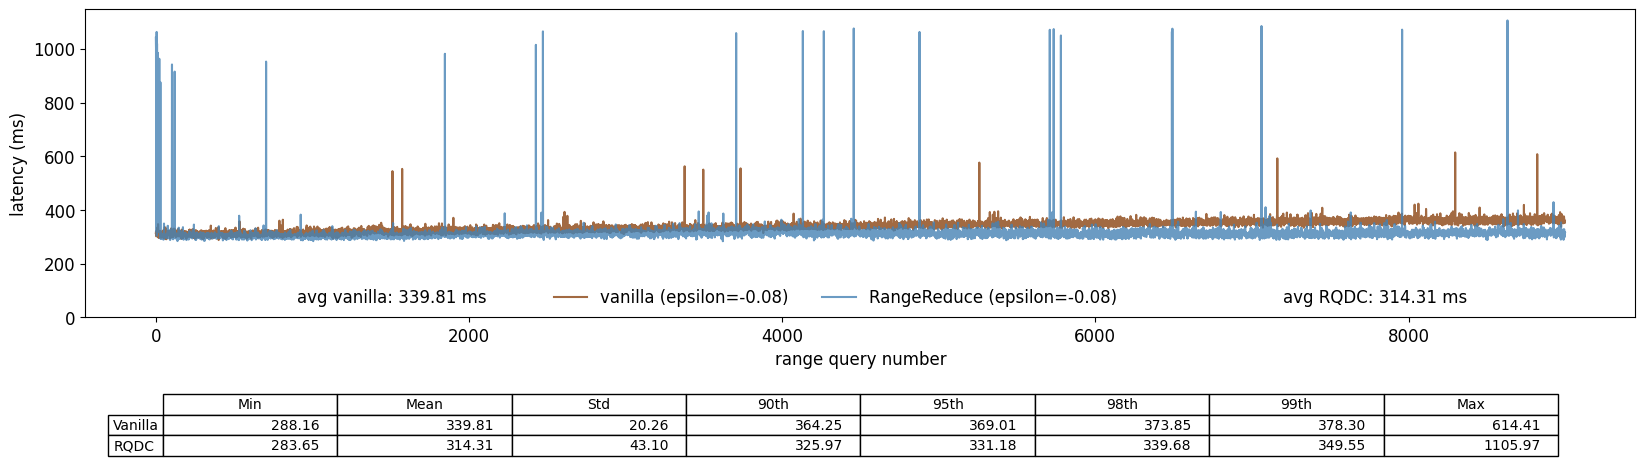

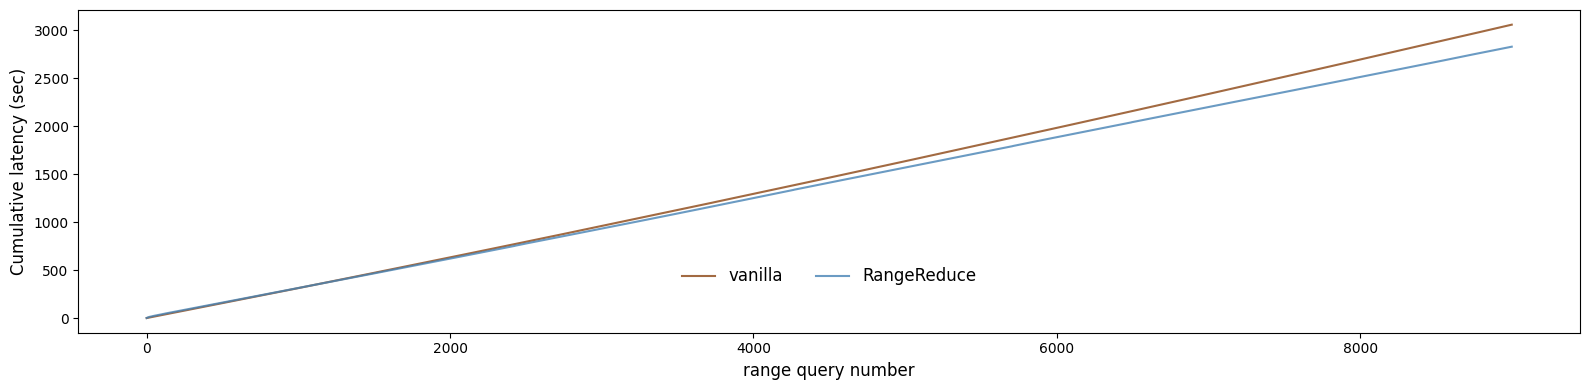

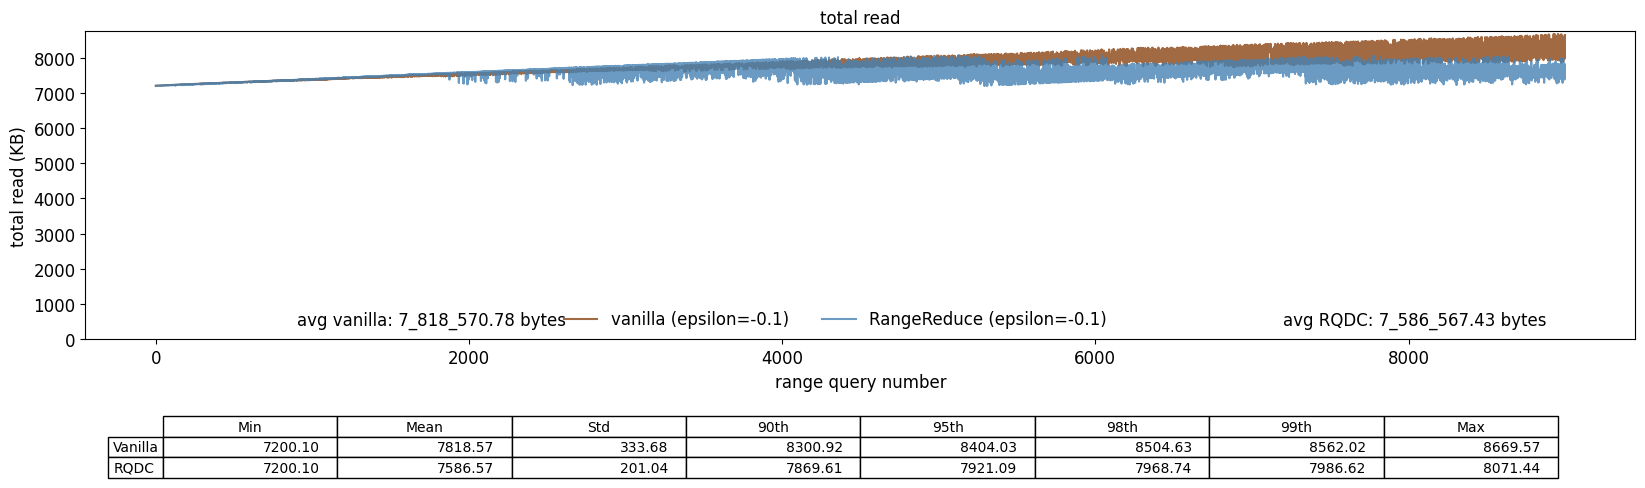

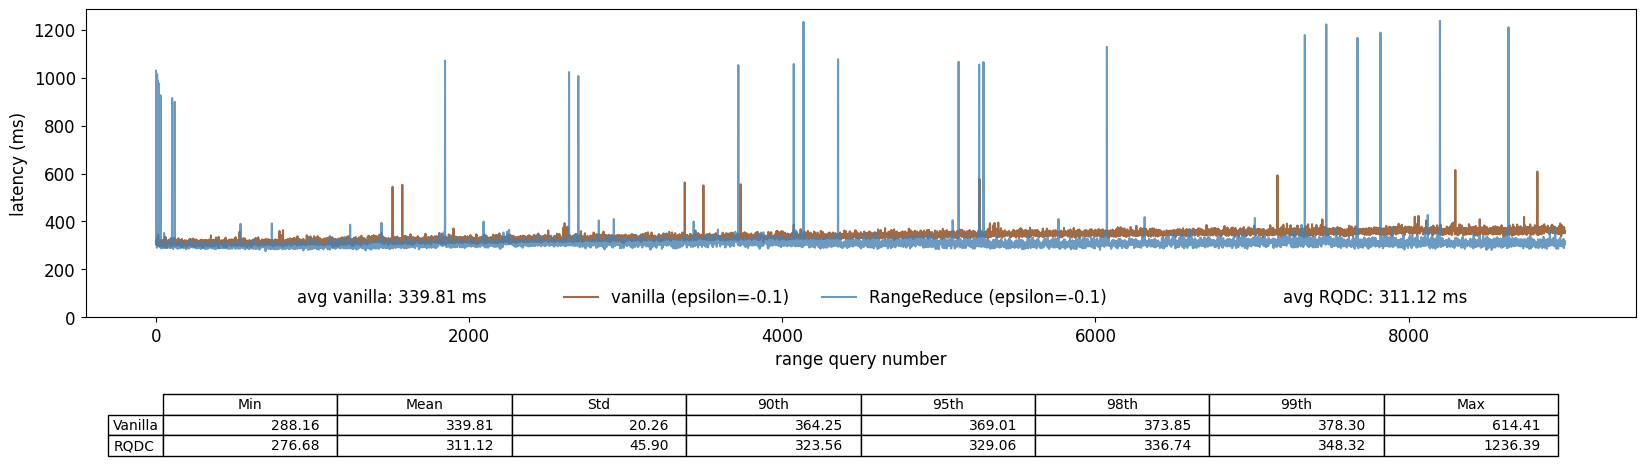

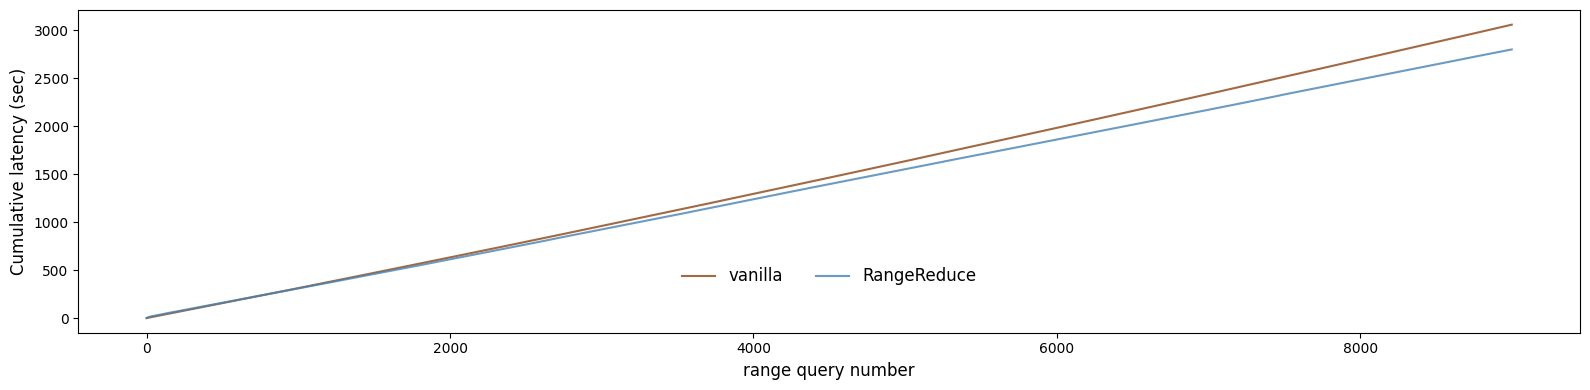

In [3]:
random_rq_stats = dict()
random_rq_stats_for_rq = dict()

# same_rq_stats = dict()
# same_rq_stats_for_rq = dict()

# overlapping_rq_stats = dict()
# overlapping_rq_stats_for_rq = dict()

for epsilon in EPSILON_VALUES:
    lb = 1/(SIZE_RATIO + (SIZE_RATIO * epsilon))
    EXPDIRNAME = f"{PROJECT_DIR}/.vstats/experiments-{TAG}-U{UPDATES}-E{ENTRY_SIZE}-B{ENTRIES_PER_PAGE}-S{RANGE_QUERIES}-Y{SELECTIVITY}-T{SIZE_RATIO}"
    vandirpath = os.path.join(EXPDIRNAME, "VanillaRandom")
    rqdcdirpath = os.path.join(EXPDIRNAME, f"RangeReduceRandom{epsilon}")

    # vandirpath_overlapping_full = os.path.join(EXPDIRNAME, "VanillaOverlappingFull")
    # rqdcdirpath_overlapping_full = os.path.join(EXPDIRNAME, "RangeReduceOverlappingFull")

    # vandirpath_overlapping_partial = os.path.join(EXPDIRNAME, "VanillaOverlappingPartial")
    # rqdcdirpath_overlapping_partial = os.path.join(EXPDIRNAME, "RangeReduceOverlappingPartial")

    filesize = ENTRY_SIZE * ENTRIES_PER_PAGE * NUM_PAGE_PER_FILE

    van = EpochStats(vandirpath, NUMEPOCHS, filesize)
    rqdc = EpochStats(rqdcdirpath, NUMEPOCHS, filesize)

    # van_same_rq = EpochStats(vandirpath_overlapping_full, NUMEPOCHS, filesize)
    # rqdc_same_rq = EpochStats(rqdcdirpath_overlapping_full, NUMEPOCHS, filesize)

    # van_overlapping_rq = EpochStats(vandirpath_overlapping_partial, NUMEPOCHS, filesize)
    # rqdc_overlapping_rq = EpochStats(rqdcdirpath_overlapping_partial, NUMEPOCHS, filesize)

    random_rq_stats[SELECTIVITY] = SelectivityVsMetric(
        Vanilla=van.get_plotstats()[0],
        RangeReduce=rqdc.get_plotstats()[0],
    )

    # same_rq_stats[selectivity] = SelectivityVsMetric(
    #     Vanilla=van_same_rq.get_plotstats()[0],
    #     RangeReduce=rqdc_same_rq.get_plotstats()[0],
    # )

    # overlapping_rq_stats[selectivity] = SelectivityVsMetric(
    #     Vanilla=van_overlapping_rq.get_plotstats()[0],
    #     RangeReduce=rqdc_overlapping_rq.get_plotstats()[0],
    # )

    random_rq_stats_for_rq[SELECTIVITY] = SelectivityVsRangeQueryMetric(
        Vanilla=van.get_rangequerystats(),
        RangeReduce=rqdc.get_rangequerystats(),
    )

    # same_rq_stats_for_rq[selectivity] = SelectivityVsRangeQueryMetric(
    #     Vanilla=van_same_rq.get_rangequerystats(),
    #     RangeReduce=rqdc_same_rq.get_rangequerystats(),
    # )

    # overlapping_rq_stats_for_rq[selectivity] = SelectivityVsRangeQueryMetric(
    #     Vanilla=van_overlapping_rq.get_rangequerystats(),
    #     RangeReduce=rqdc_overlapping_rq.get_rangequerystats(),
    # )
    plot_exp = PlotRangeQueryStats(van.get_rangequerystats(), rqdc.get_rangequerystats())
    plot_exp.bytes_read_for_each_range_query(f"(epsilon={epsilon})")
    plot_exp.latency_for_each_range_query(f"(epsilon={epsilon})")
    plot_exp.cummulative_latency_for_range_queries(f"(epsilon={epsilon})")

In [4]:
# random_selectivities = PlotSelectivities(random_rq_stats)
# same_rq_selectivities = PlotSelectivities(same_rq_stats)
# overlapping_rq_selectivities = PlotSelectivities(overlapping_rq_stats)

In [5]:
# random_selectivities.plot_total_bytes_written(tag="random")
# same_rq_selectivities.plot_total_bytes_written(tag="same")
# overlapping_rq_selectivities.plot_total_bytes_written(tag="overlapping")

In [6]:
# random_selectivities.plot_compaction_debt(tag="random")
# same_rq_selectivities.plot_compaction_debt(tag="same")
# overlapping_rq_selectivities.plot_compaction_debt(tag="overlapping")

In [7]:
# random_selectivities.plot_write_amp_debt(tag="random")
# same_rq_selectivities.plot_write_amp_debt(tag="same")
# overlapping_rq_selectivities.plot_write_amp_debt(tag="overlapping")

In [8]:
# random_selectivities.plot_write_amp_full_debt(tag="random")
# same_rq_selectivities.plot_write_amp_full_debt(tag="same")
# overlapping_rq_selectivities.plot_write_amp_full_debt(tag="overlapping")

In [9]:
# random_selectivities.plot_space_amplification(tag="random")
# same_rq_selectivities.plot_space_amplification(tag="same")
# overlapping_rq_selectivities.plot_space_amplification(tag="overlapping")

In [10]:
# random_selectivities.plot_compaction_read(tag="random")
# same_rq_selectivities.plot_compaction_read(tag="same")
# overlapping_rq_selectivities.plot_compaction_read(tag="overlapping")

In [11]:
# PlotSelectivities.plot_total_data_movement(random_rq_stats, random_rq_stats_for_rq, tag="random")
# PlotSelectivities.plot_total_data_movement(same_rq_stats, same_rq_stats_for_rq, tag="same")
# PlotSelectivities.plot_total_data_movement(overlapping_rq_stats, overlapping_rq_stats_for_rq, tag="overlapping")

In [12]:
# random_selectivities_rq = PlotSelectivitiesRangeQuery(random_rq_stats_for_rq)
# same_rq_selectivities_rq = PlotSelectivitiesRangeQuery(same_rq_stats_for_rq)
# overlapping_rq_selectivities_rq = PlotSelectivitiesRangeQuery(overlapping_rq_stats_for_rq)

In [13]:
# random_selectivities_rq.avg_bytes_read_for_range_queries(tag='random')
# same_rq_selectivities_rq.avg_bytes_read_for_range_queries(tag='same')
# overlapping_rq_selectivities_rq.avg_bytes_read_for_range_queries(tag='overlapping')

In [14]:
# random_selectivities_rq.avg_bytes_written_for_range_queries(tag='random')
# same_rq_selectivities_rq.avg_bytes_written_for_range_queries(tag='same')
# overlapping_rq_selectivities_rq.avg_bytes_written_for_range_queries(tag='overlapping')

In [15]:
# random_selectivities_rq.avg_latency_for_range_queries(tag='random')
# same_rq_selectivities_rq.avg_latency_for_range_queries(tag='same')
# overlapping_rq_selectivities_rq.avg_latency_for_range_queries(tag='overlapping')

In [16]:
# plot_exp = PlotRangeQueryStats(van.get_rangequerystats(), rqdc.get_rangequerystats())
# plot_exp.bytes_read_for_each_range_query()
# plot_exp.latency_for_each_range_query()
# plot_exp.bytes_written_for_each_range_query()

In [17]:
# plot_exp = PlotRangeQueryStats(van_overlapping_rq.get_rangequerystats(), rqdc_overlapping_rq.get_rangequerystats())
# plot_exp.bytes_read_for_each_range_query(range_query_pattern="Same RQ")
# plot_exp.latency_for_each_range_query(range_query_pattern="Same RQ")
# plot_exp.bytes_written_for_each_range_query()

In [18]:
# plot_exp = PlotRangeQueryStats(van_overlapping_partial.get_rangequerystats(), rqdc_overlapping_partial.get_rangequerystats())
# plot_exp.bytes_read_for_each_range_query(range_query_pattern="Overlapping RQ")
# plot_exp.latency_for_each_range_query(range_query_pattern="Overlapping RQ")
# plot_exp.bytes_written_for_each_range_query()